In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import pickle

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import statsmodels
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [2]:
lang_codes = ["ja", "ko", "tr", "sv" , "no", "fi", "da", "sr", "it" , "ca", "nl", "fr", "de"]
ctr_codes = ["JPN", "KOR", "TUR", "SWE", "NOR", "FIN", "DEN", "SER", "ITA", "SPA", "NET", "FRA", "GER"]
code_dict = dict(zip(lang_codes, ctr_codes))
country_region = {'East Asia': ['ja', 'ko'], 'West Asia': ['tr'], 'Northern Europe': ['sv', 'no', 'fi', 'da'],
        'Southern Europe': ['sr', 'it', 'ca'], 'Western Europe':['nl', 'fr', 'de'], 'North America': ['en']}

agg = pd.read_json("data/aggregated_timeseries.json.gz")
hofstede = pd.read_csv("data/6-dimensions-for-website-2015-08-16.csv", sep=";")
hofstede = hofstede[hofstede.ctr.isin(ctr_codes)].set_index('ctr').drop('country', axis=1).astype(int)
hofstede
agg

,ja.m,it,da.m,tr,no.m,en,sr,tr.m,en.m,no,...,ko.m,fi.m,sr.m,ja,fr,fi,ca,it.m,sv.m,ko
len,1197788,1594039,256451,346007,516838,6047509,632128,345790,6045654,531478,...,489181,480638,396063,1197856,2195949,481854,642031,1588312,1959446,490314
sum,"{'2018-01-01 00:00:00': 22328288, '2018-01-02 ...","{'2018-01-01 00:00:00': 3338750, '2018-01-02 0...","{'2018-01-01 00:00:00': 765123, '2018-01-02 00...","{'2018-01-01 00:00:00': 407629, '2018-01-02 00...","{'2018-01-01 00:00:00': 715031, '2018-01-02 00...","{'2018-01-01 00:00:00': 86763830, '2018-01-02 ...","{'2018-01-01 00:00:00': 192409, '2018-01-02 00...","{'2018-01-01 00:00:00': 493684, '2018-01-02 00...","{'2018-01-01 00:00:00': 135822131, '2018-01-02...","{'2018-01-01 00:00:00': 224417, '2018-01-02 00...",...,"{'2018-01-01 00:00:00': 1484496, '2018-01-02 0...","{'2018-01-01 00:00:00': 1319053, '2018-01-02 0...","{'2018-01-01 00:00:00': 451383, '2018-01-02 00...","{'2018-01-01 00:00:00': 7828155, '2018-01-02 0...","{'2018-01-01 00:00:00': 6441009, '2018-01-02 0...","{'2018-01-01 00:00:00': 523135, '2018-01-02 00...","{'2018-01-01 00:00:00': 111910, '2018-01-02 00...","{'2018-01-01 00:00:00': 12856884, '2018-01-02 ...","{'2018-01-01 00:00:00': 2383474, '2018-01-02 0...","{'2018-01-01 00:00:00': 819174, '2018-01-02 00..."
covid,"{'len': 30, 'sum': {'2018-01-01 00:00:00': 55,...","{'len': 33, 'sum': {'2018-01-01 00:00:00': 50,...","{'len': 4, 'sum': {'2018-01-01 00:00:00': 0, '...","{'len': 64, 'sum': {'2018-01-01 00:00:00': 1, ...","{'len': 10, 'sum': {'2018-01-01 00:00:00': 7, ...","{'len': 306, 'sum': {'2018-01-01 00:00:00': 57...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 6, '...","{'len': 64, 'sum': {'2018-01-01 00:00:00': 3, ...","{'len': 306, 'sum': {'2018-01-01 00:00:00': 91...","{'len': 10, 'sum': {'2018-01-01 00:00:00': 2, ...",...,"{'len': 113, 'sum': {'2018-01-01 00:00:00': 6,...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 0, '...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 11, ...","{'len': 30, 'sum': {'2018-01-01 00:00:00': 26,...","{'len': 16, 'sum': {'2018-01-01 00:00:00': 62,...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 2, '...","{'len': 49, 'sum': {'2018-01-01 00:00:00': 6, ...","{'len': 33, 'sum': {'2018-01-01 00:00:00': 139...","{'len': 8, 'sum': {'2018-01-01 00:00:00': 19, ...","{'len': 113, 'sum': {'2018-01-01 00:00:00': 3,..."
topics,{'Culture.Biography.Biography*': {'len': 14904...,{'Culture.Biography.Biography*': {'len': 29427...,{'Culture.Biography.Biography*': {'len': 57720...,{'Culture.Biography.Biography*': {'len': 70443...,{'Culture.Biography.Biography*': {'len': 11603...,{'Culture.Biography.Biography*': {'len': 14038...,{'Culture.Biography.Biography*': {'len': 37718...,{'Culture.Biography.Biography*': {'len': 70434...,{'Culture.Biography.Biography*': {'len': 14038...,{'Culture.Biography.Biography*': {'len': 11804...,...,{'Culture.Biography.Biography*': {'len': 75406...,{'Culture.Biography.Biography*': {'len': 10422...,{'Culture.Biography.Biography*': {'len': 37580...,{'Culture.Biography.Biography*': {'len': 14904...,{'Culture.Biography.Biography*': {'len': 38258...,{'Culture.Biography.Biography*': {'len': 10444...,{'Culture.Biography.Biography*': {'len': 10175...,{'Culture.Biography.Biography*': {'len': 29422...,{'Culture.Biography.Biography*': {'len': 14668...,{'Culture.Biography.Biography*': {'len': 75498...


In [3]:
dfs = []
codes = lang_codes + [x + '.m' for x in lang_codes]

dfs = []

for language in codes:
    language_data = agg[language]
    all_sum = pd.Series(agg[language]['sum'])
    if 0 in all_sum.values:
        all_sum.replace(0, 1, inplace=True)
    
    for topic, topic_data in language_data["topics"].items():
        topic_sum = pd.Series(topic_data['sum']) # number of pageviews per day for a topic
        topic_df = pd.DataFrame({
            'pageviews': topic_sum.values,
            'language': [language] * len(topic_sum),
            'date': topic_sum.index,
            'topic': [topic] * len(topic_sum),
            'proportion': np.divide(topic_sum.values, all_sum.values)
        })
        dfs.append(topic_df)
        
df = pd.concat(dfs, ignore_index=True)
df.date = pd.to_datetime(df.date)

In [4]:
df_desktop = df[df.language.apply(lambda l : l in lang_codes)]
df_mobile = df[df.language.apply(lambda l : l[-2:] == ".m")]
df_mobile.loc[:,"language"] = df_mobile.language.apply(lambda l: l[:-2])
df = pd.concat([df_desktop, df_mobile]).groupby(["language", "topic", "date"]).sum().reset_index()
df["log_views"] = np.log(df.pageviews)
df.head()

,language,topic,date,pageviews,proportion,log_views
0,ca,Culture.Biography.Biography*,2018-01-01,68986,0.465804,11.141659
1,ca,Culture.Biography.Biography*,2018-01-02,65138,0.385468,11.084263
2,ca,Culture.Biography.Biography*,2018-01-03,62817,0.382883,11.047981
3,ca,Culture.Biography.Biography*,2018-01-04,67250,0.393519,11.116172
4,ca,Culture.Biography.Biography*,2018-01-05,57697,0.389505,10.962960


In [33]:
lang_codes = ["ja", "ko", "tr", "sv" , "no", "fi", "da", "sr", "it" , "ca", "nl", "fr", "de"]
ctr_codes = ["JPN", "KOR", "TUR", "SWE", "NOR", "FIN", "DEN", "SER", "ITA", "SPA", "NET", "FRA", "GER"]
code_dict = dict(zip(lang_codes, ctr_codes))
country_region = {'East Asia': ['ja', 'ko'], 'West Asia': ['tr'], 'Northern Europe': ['sv', 'no', 'fi', 'da'],
        'Southern Europe': ['sr', 'it', 'ca'], 'Western Europe':['nl', 'fr', 'de'], 'North America': ['en']}

agg = pd.read_json("data/aggregated_timeseries.json.gz")
hofstede = pd.read_csv("data/6-dimensions-for-website-2015-08-16.csv", sep=";")
hofstede = hofstede[hofstede.ctr.isin(ctr_codes)].set_index('ctr').drop('country', axis=1).astype(int)
hofstede

,pdi,idv,mas,uai,ltowvs,ivr
ctr,,,,,,
DEN,18,74,16,23,35,70
FIN,33,63,26,59,38,57
FRA,68,71,43,86,63,48
GER,35,67,66,65,83,40
ITA,50,76,70,75,61,30
JPN,54,46,95,92,88,42
KOR,60,18,39,85,100,29
NET,38,80,14,53,67,68
NOR,31,69,8,50,35,55


In [92]:
prop = df[['topic', 'language', 'proportion']].groupby(['topic', 'language']).agg(['mean'])
topics = prop.index.get_level_values('topic').unique()
correlation = []

for topic in topics:
    for dim in hofstede.columns:
        series = prop.loc[topic]['proportion']
        series.index = series.index.map(code_dict)
        series = series.sort_index()
        corr = hofstede[dim].corr(series['mean'])
        correlation.append({'topic': topic, 'dimension': dim, 'correlation': corr})
corr_df = pd.DataFrame(correlation).pivot(index='topic', columns='dimension', values='correlation')

Text(0.5, 1.0, 'Correlation between Individuality and Page Views Trends in countries')

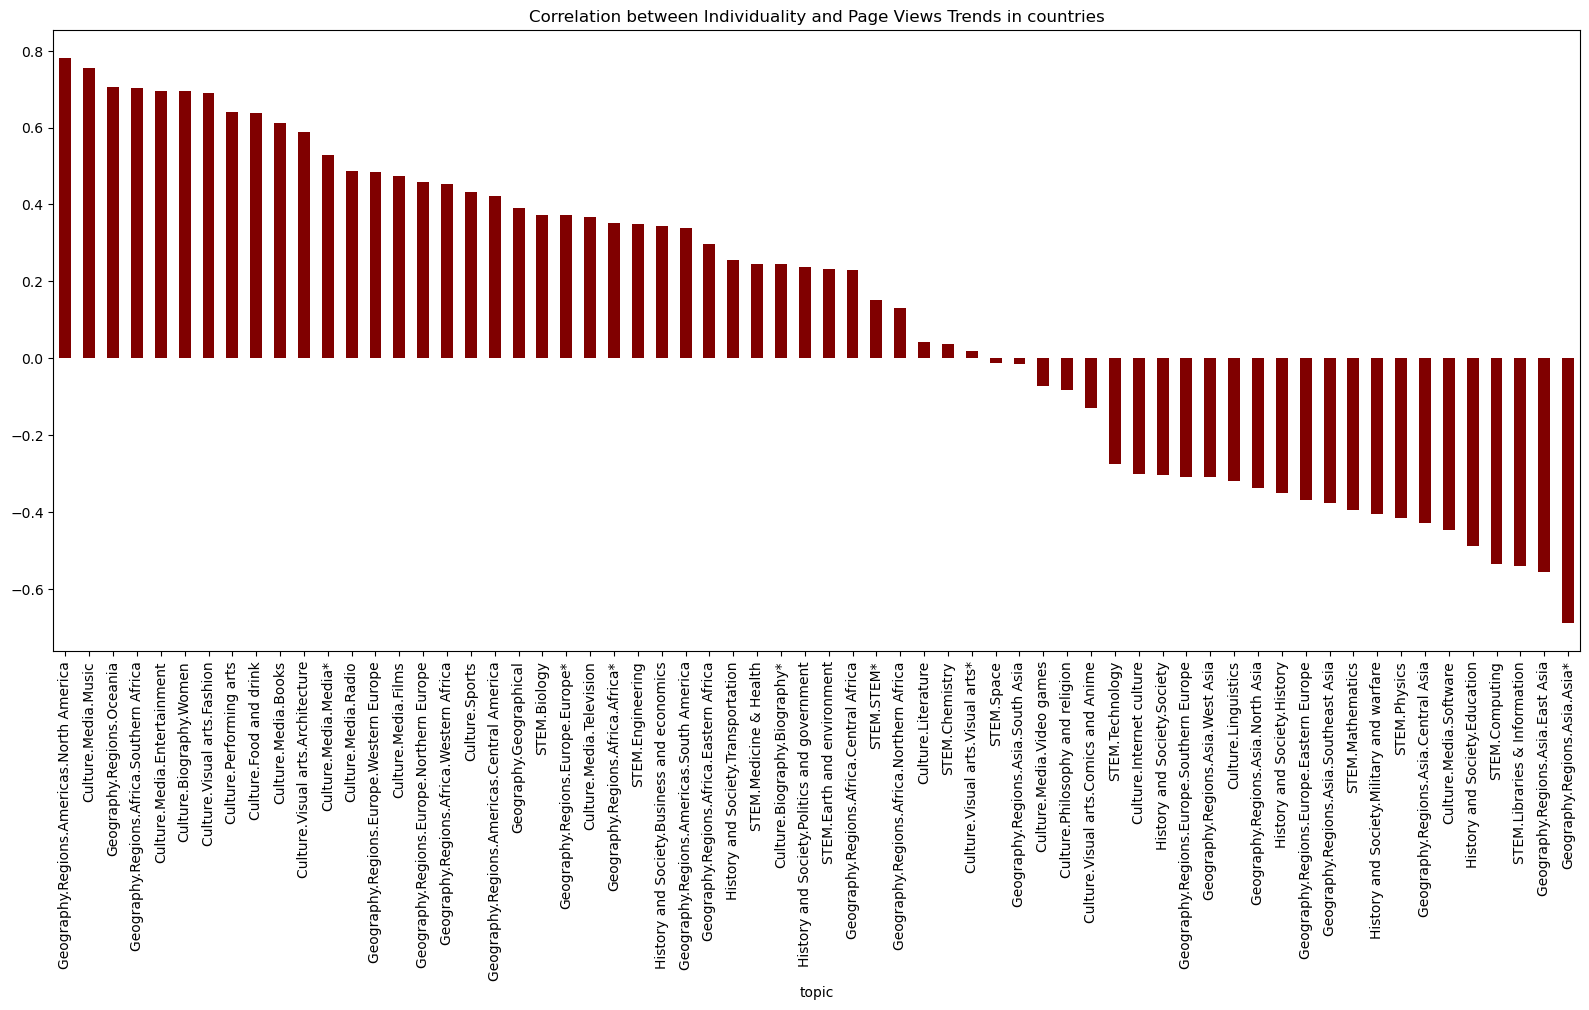

In [93]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
corr_df['idv'].sort_values(ascending=False).plot.bar(x = "topic", y = "correlation", ax=ax,color ='maroon')
fig.tight_layout()
ax.set_title("Correlation between Individuality and Page Views Trends in countries")

Text(0.5, 1.0, 'Correlation between Indulgence/Restraint and Page Views Trends in countries')

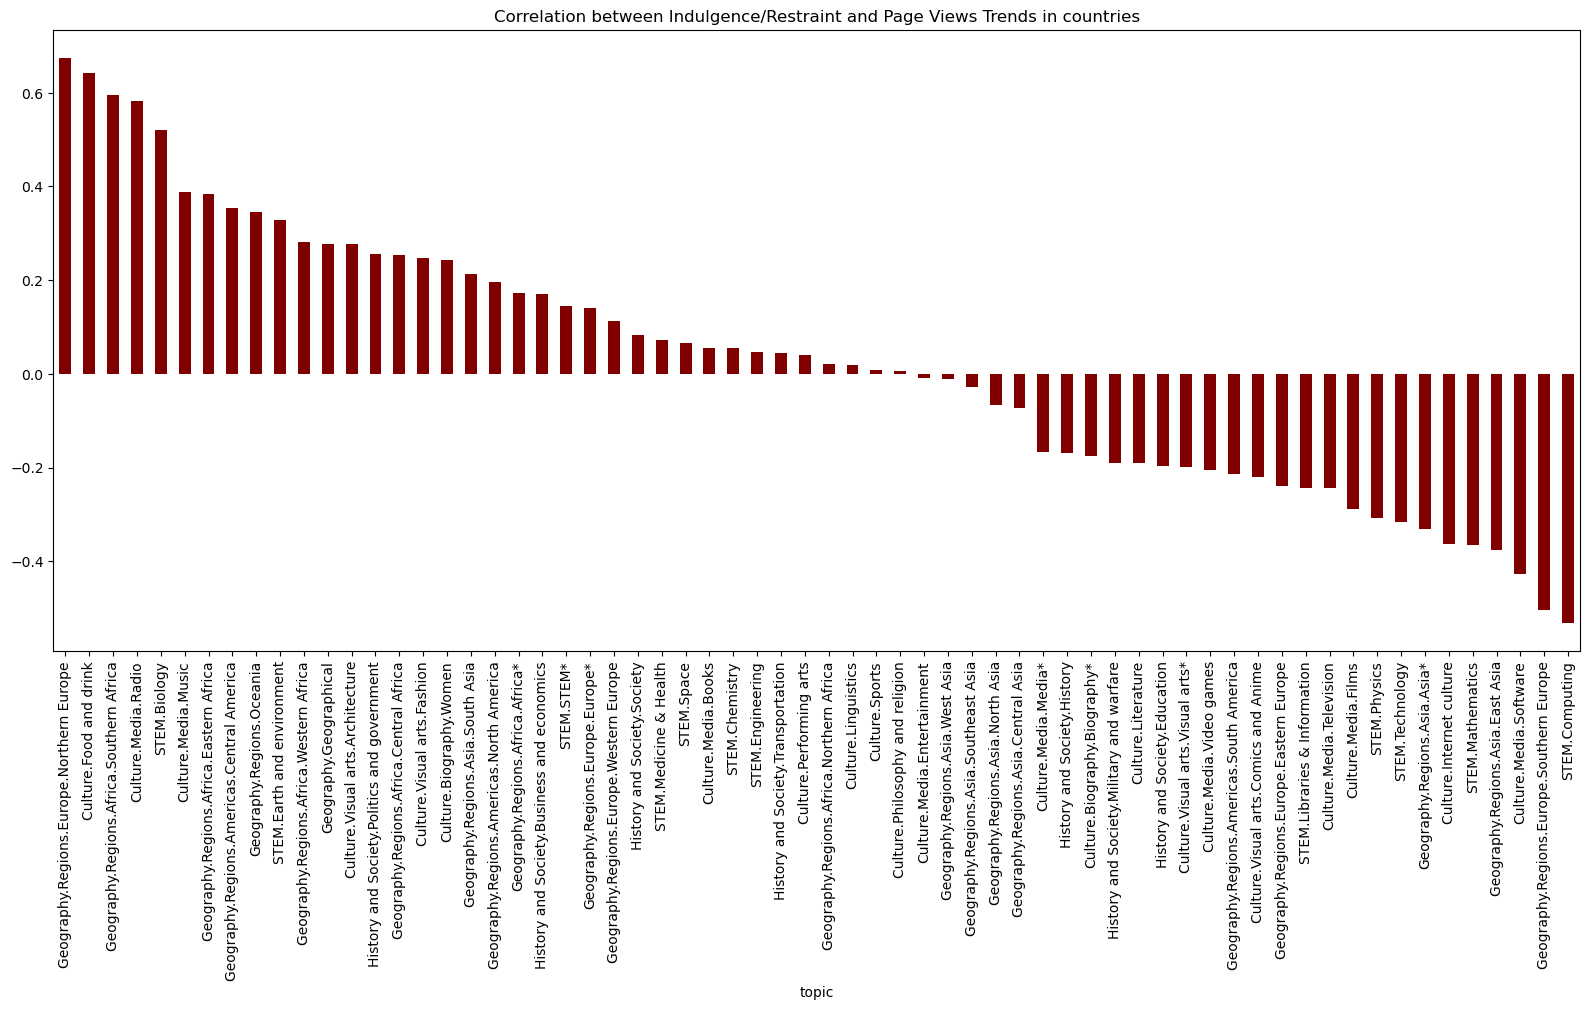

In [95]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
corr_df['ivr'].sort_values(ascending=False).plot.bar(x = "topic", y = "correlation", ax=ax,color ='maroon')
fig.tight_layout()
ax.set_title("Correlation between Indulgence/Restraint and Page Views Trends in countries")

Text(0.5, 1.0, 'Correlation between Long Term/Short Term orientation and Page Views Trends in countries')

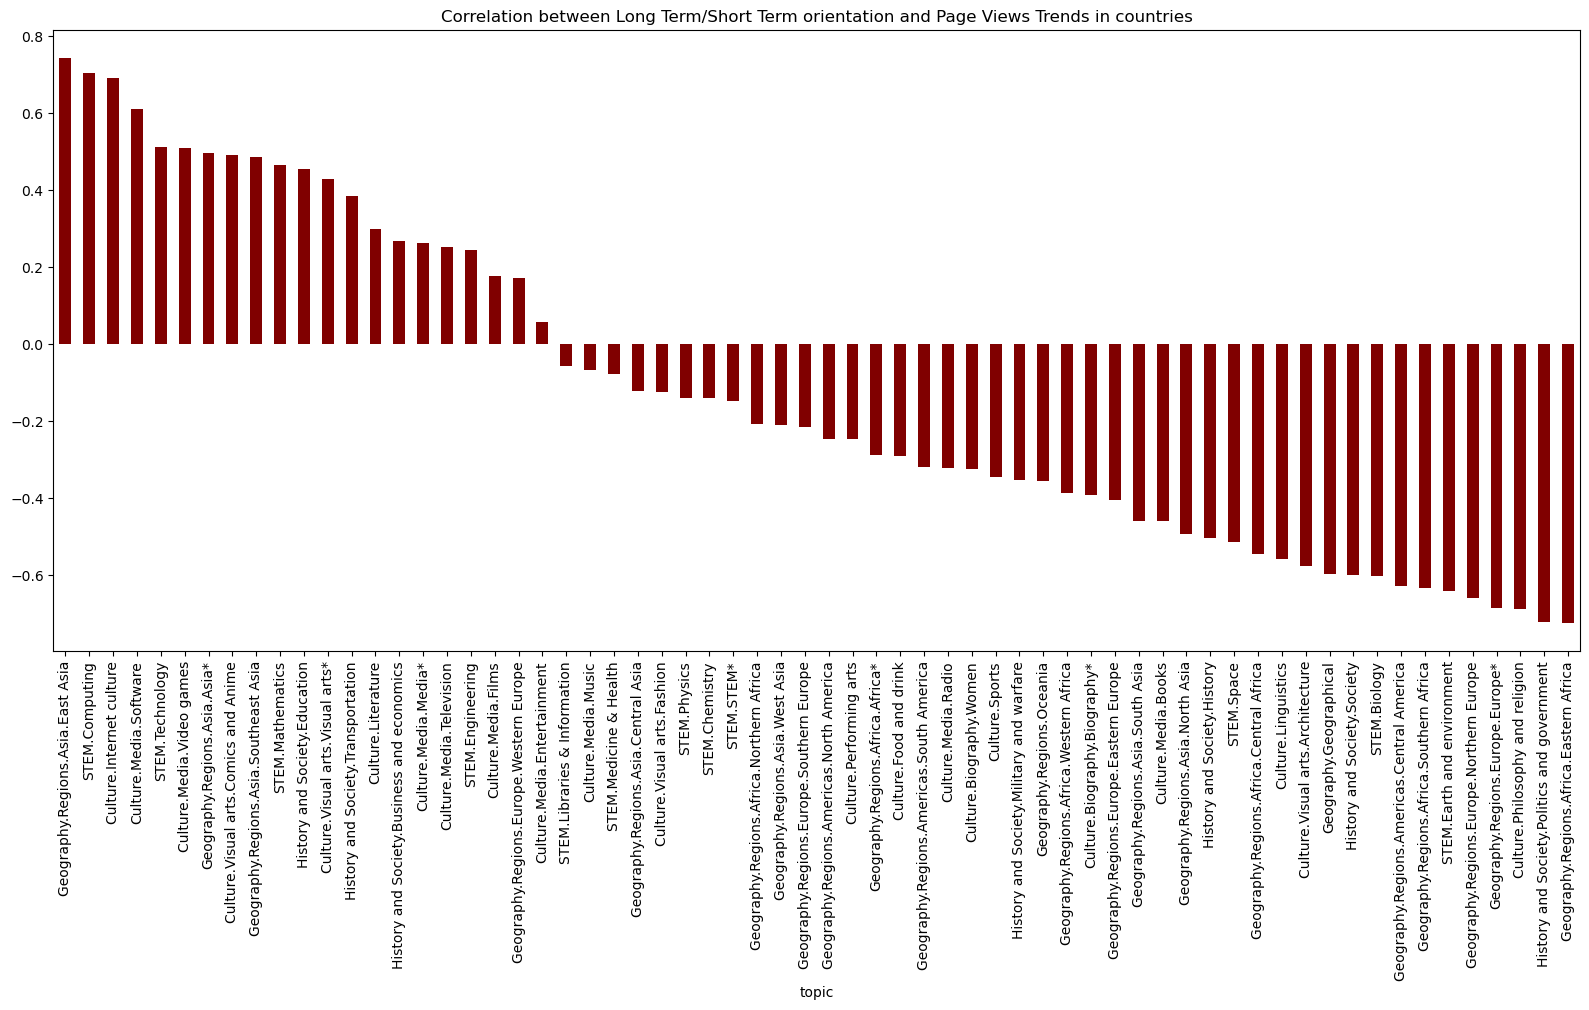

In [100]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
corr_df["ltowvs"].sort_values(ascending=False).plot.bar(x = "topic", y = "correlation", ax=ax,color ='maroon')
fig.tight_layout()
ax.set_title("Correlation between Long Term/Short Term orientation and Page Views Trends in countries")

Text(0.5, 1.0, 'Correlation between Masculinity and Page Views Trends in countries')

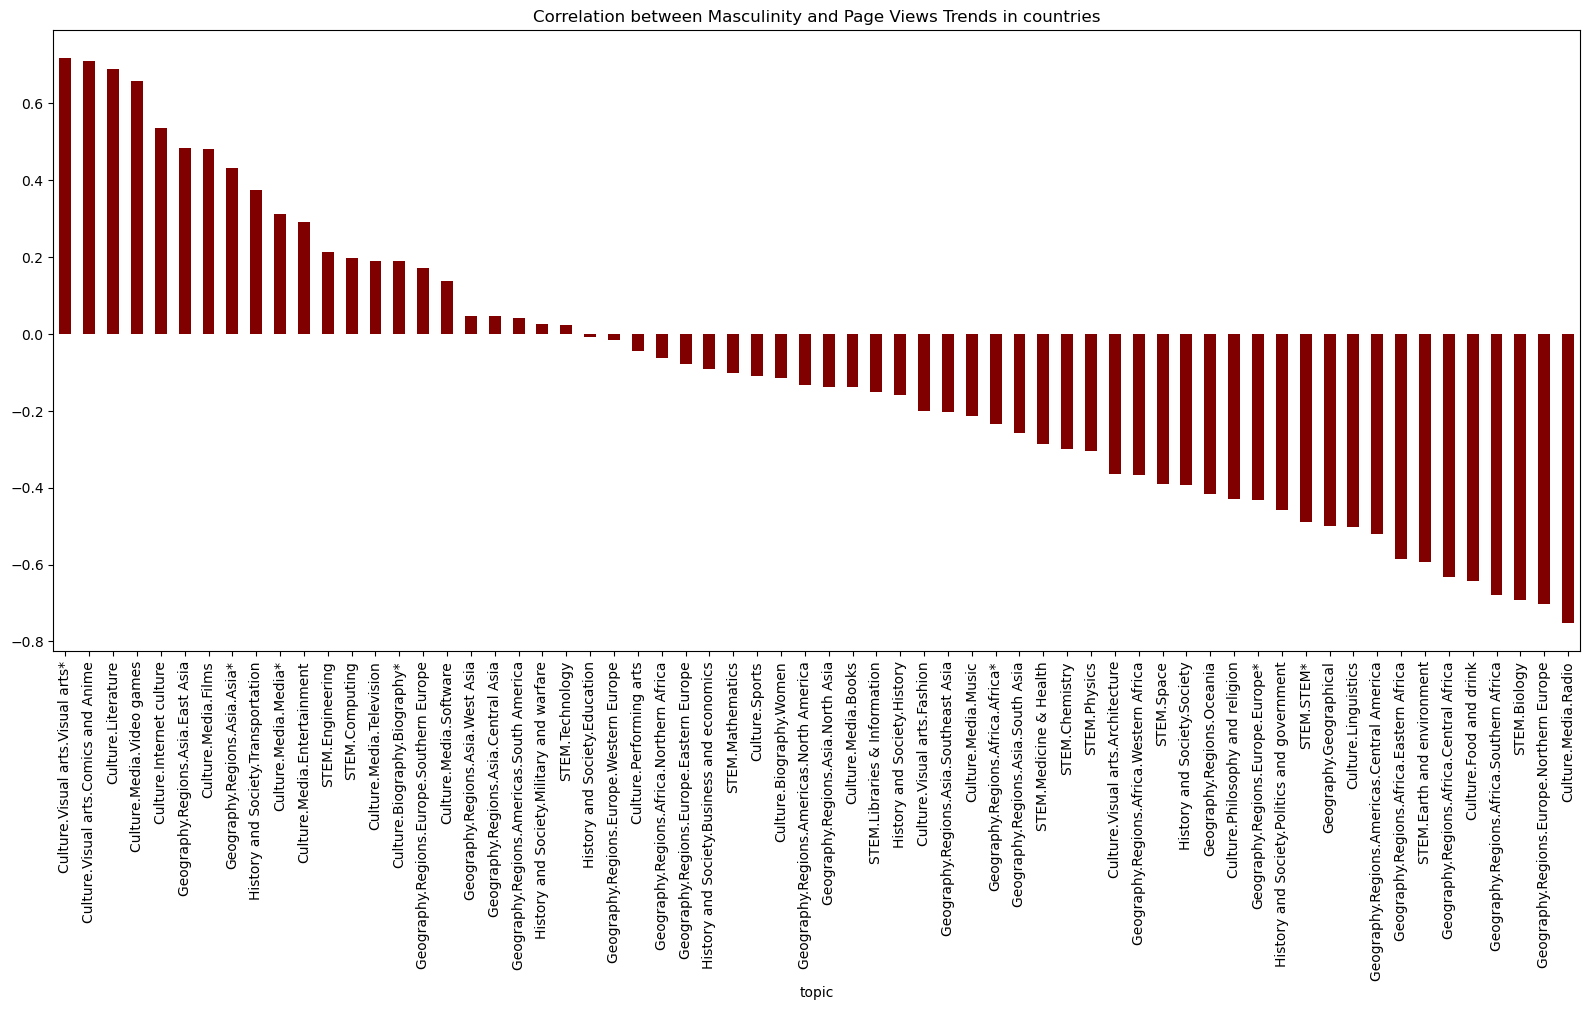

In [101]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
corr_df["mas"].sort_values(ascending=False).plot.bar(x = "topic", y = "correlation", ax=ax,color ='maroon')
fig.tight_layout()
ax.set_title("Correlation between MAS and Page Views Trends in countries")

Text(0.5, 1.0, 'Correlation between Uncertainty Avoidance and Page Views Trends in countries')

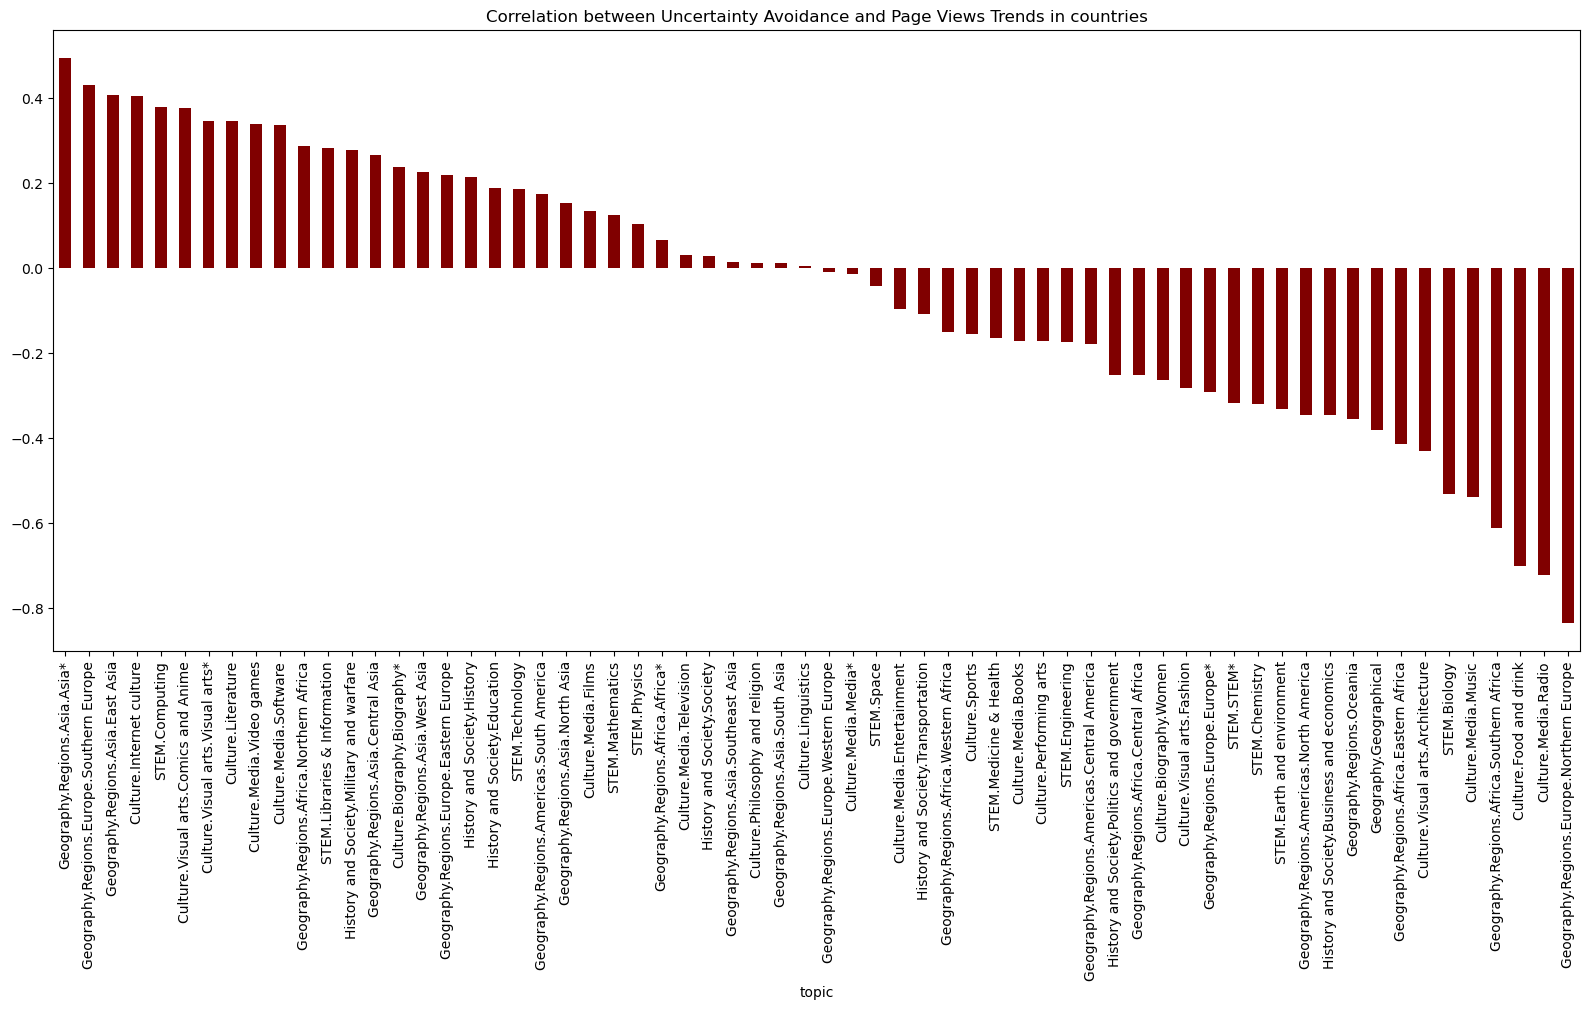

In [105]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
corr_df["uai"].sort_values(ascending=False).plot.bar(x = "topic", y = "correlation", ax=ax,color ='maroon')
fig.tight_layout()
ax.set_title("Correlation between Uncertainty Avoidance and Page Views Trends in countries")

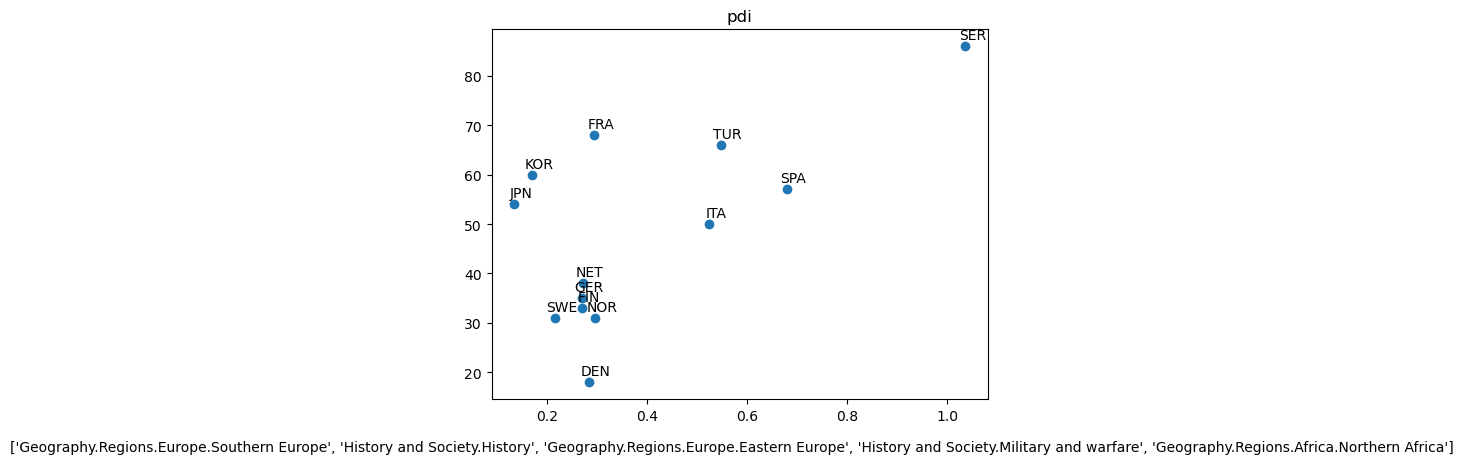

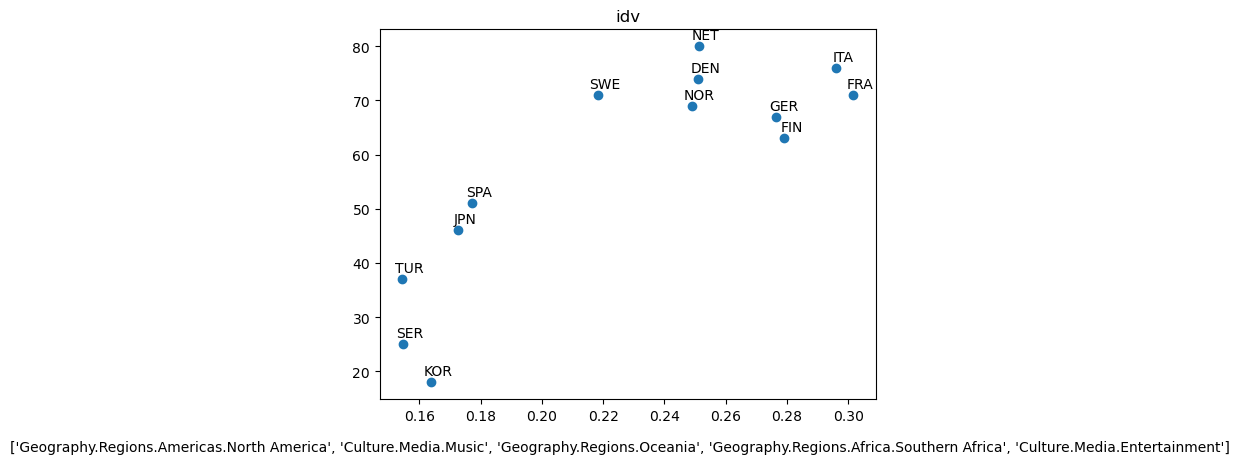

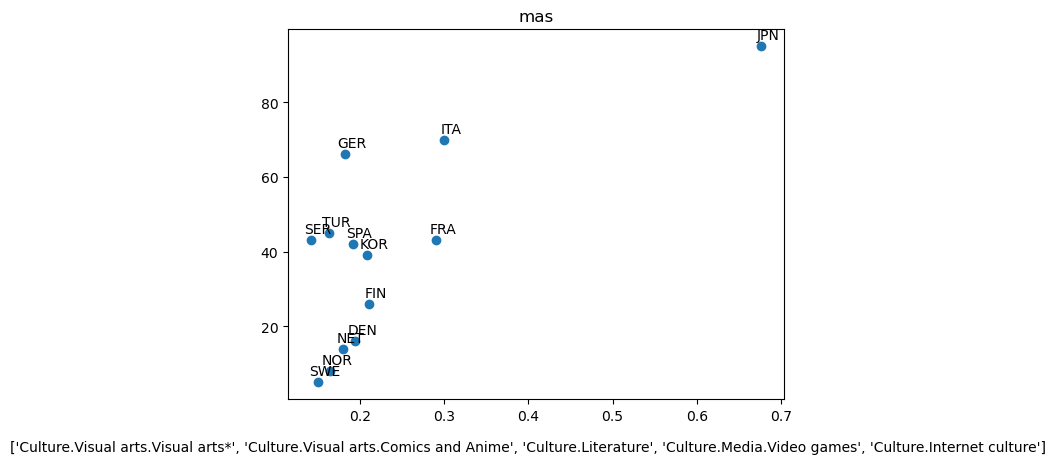

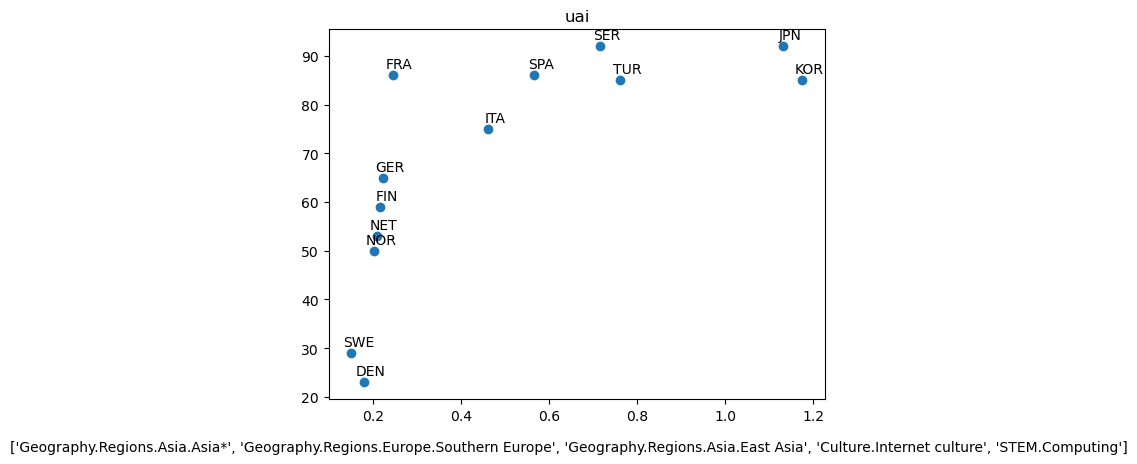

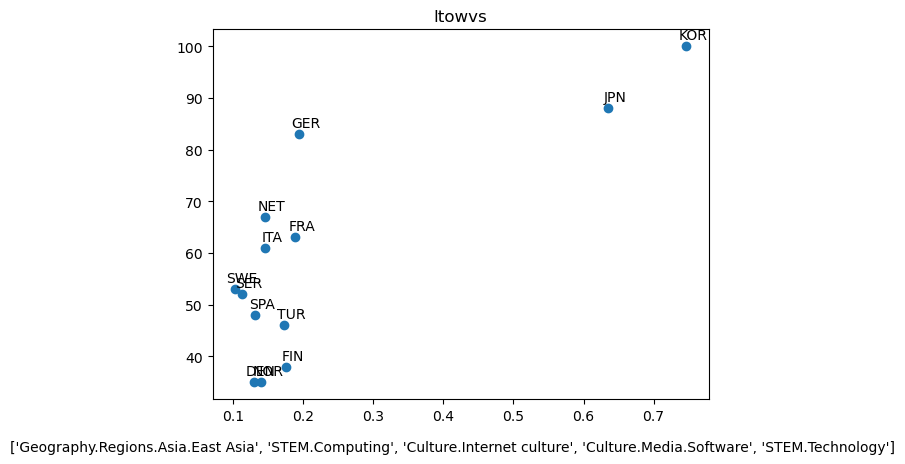

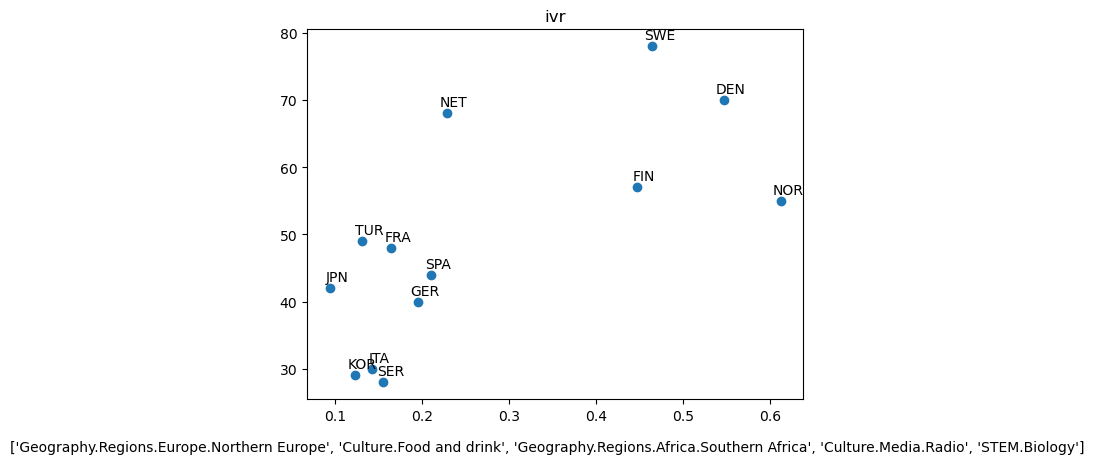

In [124]:
for dim in hofstede.columns:
    top5 = corr_df[dim].sort_values(ascending=False)[:5]
    series_list = []
    for topic in top5.index:
        series = prop.loc[topic]['proportion']
        series.index = series.index.map(code_dict)
        series = series.sort_index()
        series_list.append(series)
    series = sum(series_list)
    x = series.values.flatten()
    y = hofstede[dim].values
    plt.figure()
    plt.scatter(x,y)
    for i, label in enumerate(series.index):
        plt.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(5,5), ha='center')
    plt.title(dim)
    plt.figtext(0.5, 0.01, list(top5.index), ha='center', va='center')
